<a href="https://colab.research.google.com/github/afr0thunder/PyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow

* data - preparing and loading
* build model
* fitting the model to the data (training)
* Making predicitions and evaluating a model (inference)
* saving and loading a model
* putting it all together

In [3]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.0.1+cu118'

kaiser_window,
kaiser_window,
## 1. Data (preparing and loading)
Data can be almost anything... in machine learning

* Excel spreadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numberical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using linear regression.

We'll use a linear regression formula to make a straight line with *known* parameters.

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
### Spliting data into training and test sets

# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

How might we better vizualize our data?

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  '''
  plots training data, test data and compares predicitons
  '''
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  # Are there predictions
  if predictions is not None:
    # Plot the predicitions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
  # Show the legend
  plt.legend(prop={'size': 14})

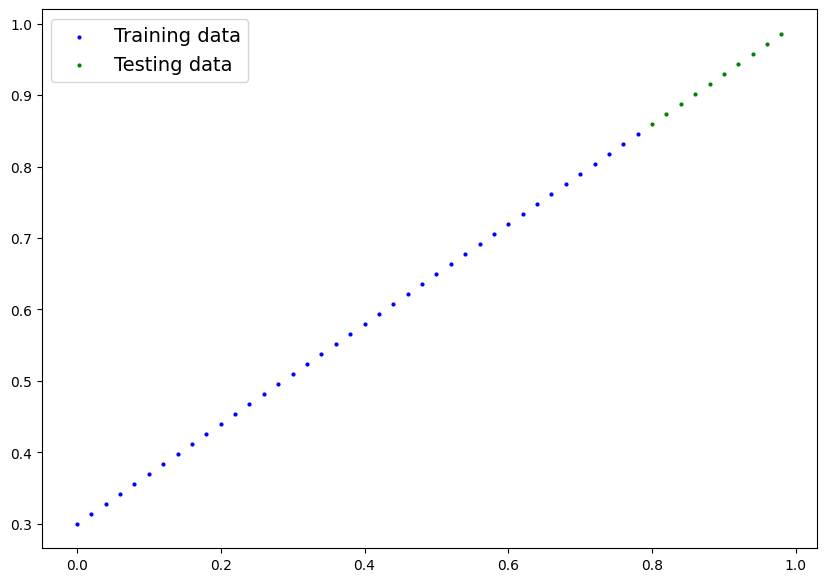

In [7]:
plot_predictions()

## 2. Build model

Finds the values for weight and bias using gradient descent and backpropagation
- https://youtu.be/IHZwWFHWa-w
- https://youtu.be/llg3gGewQ5U

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [9]:
from torch.autograd import forward_ad


### PyTorch model building essentials

1. torch.nn - contains building blocks for computational models
2. torch.nn.Parameter - what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
3. torch.nn.Module - The base class for all nn module, if you subclass it, you should overwrite forward()
4. torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
5. def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of your pytorch model

Check the model parameters of what's inside the model using `.parameters()`

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instance if the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predicitions using `torch.inference_mode()`

Pass data through the model and run it thru the forward() method

In [12]:
# Make predicitions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

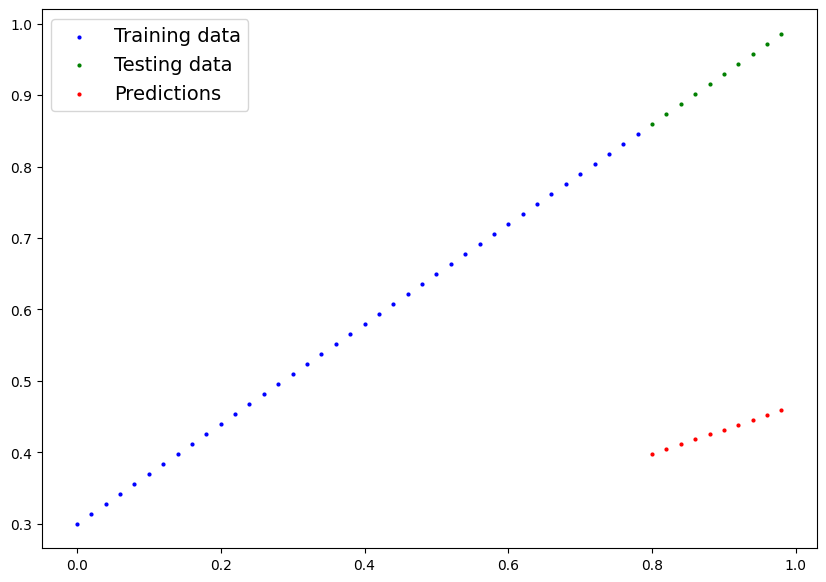

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is to move from some *unknown* paramters to some *known* parameters

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or citerion in different areas.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predicitions are to the ideal outputs, lower is better
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter (weight and bias)

Need a training loop and a testing loop



In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.0005) # lr = learning rate = very important, how much it adjusts parameters increment, hyperparameter

### Building a training and testing loops in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through the model's `forward()` functions) to make predicitions on the data - also called forward propagation
2. Calculate the loss (compare forward pass predicitions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients if each of the parameters of the model with respect to the loss - backpropagation
5. Optimizer step - use the optimizer to adjust the model's parameters to try and improve the loss - gradient descent


In [15]:
# An epoch is one loop through the data
epochs = 10000

### Training
# 0. Loop thourgh the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all paramters that require gradients to require gradients

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off gradient tracking
  with torch.inference_mode(): # turns off gradient tracking and other parameters not needed for testing
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  print (f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


  # Print out model state_dict()
  print(model_0.state_dict())

Streaming output truncated to the last 5000 lines.
Epoch: 7500 | Loss: 0.00034949928522109985 | Test loss: 0.0001248538465006277
OrderedDict([('weights', tensor([0.6998])), ('bias', tensor([0.3003]))])
Epoch: 7501 | Loss: 0.0002265505463583395 | Test loss: 0.0005486964946612716
OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.2998]))])
Epoch: 7502 | Loss: 0.00034949928522109985 | Test loss: 0.0001248538465006277
OrderedDict([('weights', tensor([0.6998])), ('bias', tensor([0.3003]))])
Epoch: 7503 | Loss: 0.0002265505463583395 | Test loss: 0.0005486964946612716
OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.2998]))])
Epoch: 7504 | Loss: 0.00034949928522109985 | Test loss: 0.0001248538465006277
OrderedDict([('weights', tensor([0.6998])), ('bias', tensor([0.3003]))])
Epoch: 7505 | Loss: 0.0002265505463583395 | Test loss: 0.0005486964946612716
OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.2998]))])
Epoch: 7506 | Loss: 0.00034949928522109985 | T

In [16]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

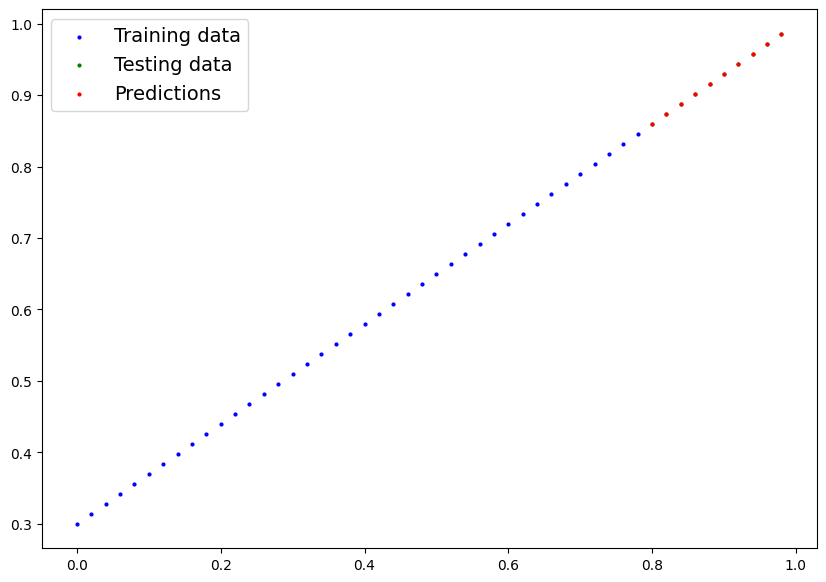

In [17]:
plot_predictions(predictions=y_preds_new)

### Saving a model in pytorch

1. torch.save()
2. torch.load()
3. torch.nn.Module.load_state_dict()

In [18]:
# Saving PyTorch Model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save Path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [19]:
# Load PyTorch Model
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of Model_0 into new instance loaded_model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>